### Predict whether  a movie is profitable.

First, we need to define the profit of a movie. 

In this work, we use 
$$revenue-budget$$
to define a movie is profitable or not.

$$revenue-budget>0$$ 
we think the movie is profitable no matter how money it earned.
$$revenue-budget<=0$$
we think the movie is nonprofitable as it lost money.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from census import Census
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as sps
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNetCV,LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score,precision_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
import sklearn
import warnings
warnings.filterwarnings("ignore")
from functions import metric_count

In [2]:
movie_data=pd.read_csv('movies_for_RQ1.csv')

In [3]:
train, test = train_test_split(movie_data, test_size=0.25, random_state=12345)

<AxesSubplot:>

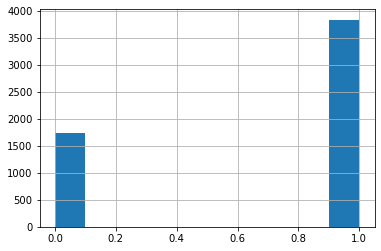

In [4]:
train['if_profit'].hist()

### The majority classification

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1739
         1.0       0.69      1.00      0.82      3835

    accuracy                           0.69      5574
   macro avg       0.34      0.50      0.41      5574
weighted avg       0.47      0.69      0.56      5574



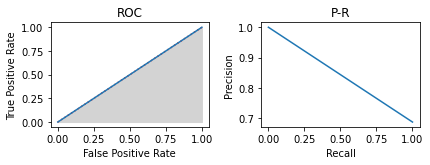

In [5]:
train['majority-class classifier']=1
metric_count(train['if_profit'],train['majority-class classifier'])

### Feature engineering

#### 1. average ratings from movielens.

average rating shows how people like this movie. the higher average rating means higher likeness in this movie, which means people are more likely to pay the tickets to see the movie. 

Also, if the rating is high, other people would be attracted to this movie, and this movie are more likely to earn more money.

<AxesSubplot:xlabel='if_profit', ylabel='rating_mean'>

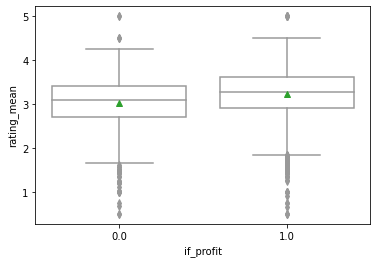

In [6]:
sns.boxplot(x='if_profit',y='rating_mean',data=train,color='white', showmeans=True)

#### 2. average ratings from TMDB

average rating shows how people like this movie. the higher average rating means higher likeness in this movie, which means people are more likely to pay the tickets to see the movie. 

Also, if the rating is high, other people would be attracted to this movie, and this movie are more likely to earn more money.

<AxesSubplot:xlabel='if_profit', ylabel='vote_average'>

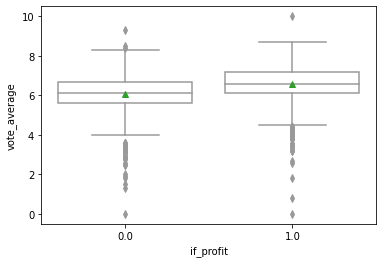

In [7]:
sns.boxplot(x='if_profit',y='vote_average',data=train,color='white', showmeans=True)

#### 3. rating_counts from movielens

if a movie's total rating number is high, it means a lot of people have seen this movie which means they are more likely to pay for the tickets to see this movie in cinima.

<AxesSubplot:xlabel='if_profit', ylabel='rating_counts'>

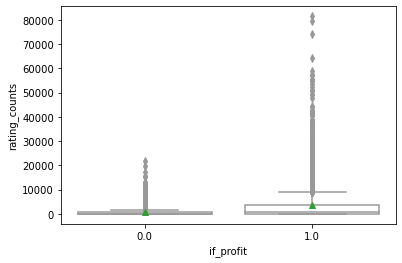

In [8]:
sns.boxplot(x='if_profit',y='rating_counts',data=train,color='white', showmeans=True)

#### it is heavily skewed. so we use log transformation

In [9]:
train['log_rating_counts']=np.log(train['rating_counts'])

<AxesSubplot:xlabel='if_profit', ylabel='log_rating_counts'>

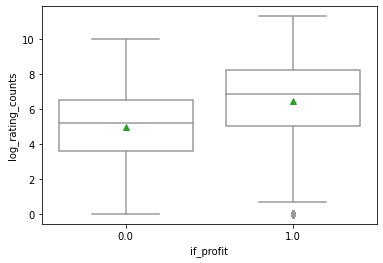

In [10]:
sns.boxplot(x='if_profit',y='log_rating_counts',data=train,color='white', showmeans=True)

#### 4. rating_counts from TMDB

if a movie's total rating number is high, it means a lot of people have seen this movie which means they are more likely to pay for the tickets to see this movie in cinima.

<AxesSubplot:xlabel='if_profit', ylabel='vote_count'>

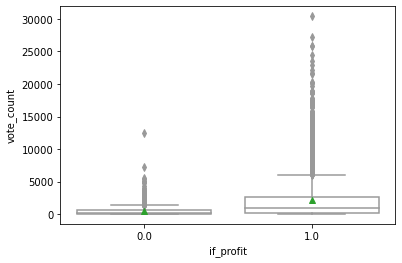

In [11]:
sns.boxplot(x='if_profit',y='vote_count',data=train,color='white', showmeans=True)

#### it is heavily skewed. so we use log transformation

<AxesSubplot:xlabel='if_profit', ylabel='log_vote_count'>

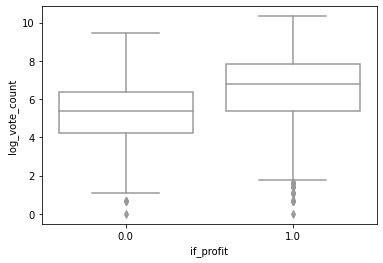

In [12]:
train['log_vote_count']=np.log(train['vote_count'])
sns.boxplot(x='if_profit',y='log_vote_count',data=train,color='white', showmeans=True)

### 5.Popularity

Popularity is a very important metric here on TMDB. It helps us boost search results, adds an incredibly useful sort value for , and is also just kind of fun to see items chart up and down.

<AxesSubplot:xlabel='if_profit', ylabel='popularity'>

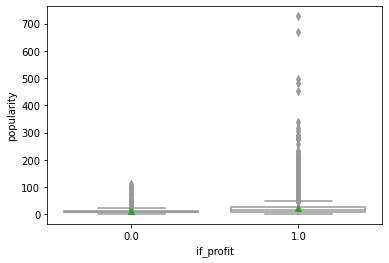

In [13]:
sns.boxplot(x='if_profit',y='popularity',data=train,color='white', showmeans=True)

#### it is heavily skewed. so we use log transformation

<AxesSubplot:xlabel='if_profit', ylabel='log_popularity'>

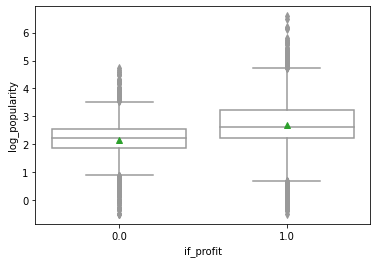

In [14]:
train['log_popularity']=np.log(train['popularity'])
sns.boxplot(x='if_profit',y='log_popularity',data=train,color='white', showmeans=True)

### 6. budget

if the budget of a movie is high, the quality of the movie would be high, and it would be more easily to earn money from auditors

<AxesSubplot:xlabel='if_profit', ylabel='budget'>

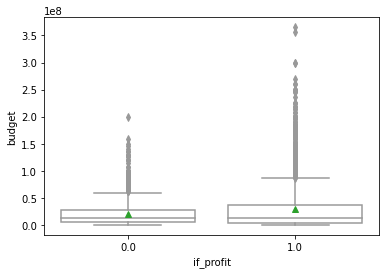

In [15]:
sns.boxplot(x='if_profit',y='budget',data=train,color='white', showmeans=True)

#### it is heavily skewed. so we use log transformation

<AxesSubplot:xlabel='if_profit', ylabel='log_budget'>

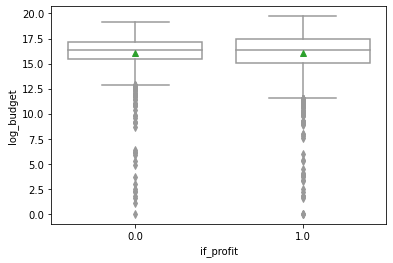

In [16]:
train['log_budget']=np.log(train['budget'])
sns.boxplot(x='if_profit',y='log_budget',data=train,color='white', showmeans=True)

### 7. the movie based on a book?

if a movie is based on a book, the story would be good, as the story in book has been evaluated by people.
but also, it would be more challenge, because people who have read that book and if it does not match their expectation, it would cause bad influence on movie revenue.

In [17]:
train.loc[train['if_have_writers']==0,
                    'if_profit'].sum()/train.loc[train['if_have_writers']==0,'if_profit'].count()

0.5925925925925926

In [18]:
train.loc[train['if_have_writers']==1,
                    'if_profit'].sum()/train.loc[train['if_have_writers']==1,'if_profit'].count()

0.6884802595997837

<AxesSubplot:xlabel='if_profit', ylabel='count'>

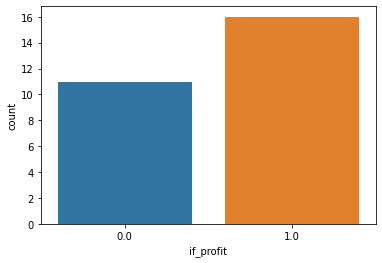

In [19]:
sns.countplot(train.loc[train['if_have_writers']==0,'if_profit'])

<AxesSubplot:xlabel='if_profit', ylabel='count'>

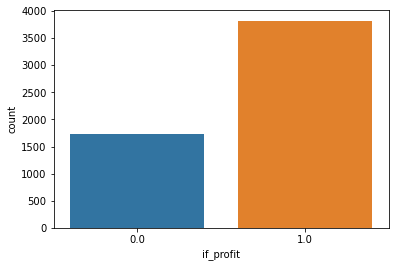

In [20]:
sns.countplot(train.loc[train['if_have_writers']==1,'if_profit'])

#### I choose 7 features in the classcification model:

1. average ratings from movielens: 'rating_mean'  -->Movielens

2. average ratings from TMDB: 'vote_average' -->Movielens

3. rating_counts from movielens: 'rating_counts' +log -->TMDB

4. rating_counts from TMDB: 'vote_count' +log -->TMDB

5. Popularity: 'popularity' +log -->TMDB

6. budget: 'budget' +log  -->TMDB

7. the movie based on a book?: 'if_have_writers' +onehot --> IMDB

#### because the data is unbalanced, I use "class_weight='balanced'" in  model to reduce the influence of unbalanced data

## LogisticRegression model

In [21]:
feat_cols = ['rating_mean','vote_average', 'rating_counts','vote_count','popularity', 
             'budget','if_have_writers',]
out_col = 'if_profit'
train_x = train[feat_cols]
train_y = train[out_col]

In [22]:
lm_pipe = Pipeline([
    ('columns', ColumnTransformer([
        
        ('log',FunctionTransformer(np.log1p),['rating_counts','vote_count','popularity','budget']),
        ('feature', OneHotEncoder(drop='first'), ['if_have_writers']),

    ])),
    ('model', LogisticRegression(class_weight='balanced',penalty='l2'))
])
lm_pipe.fit(train_x,train_y)
accuracy_score(train_y,lm_pipe.predict(train_x))

0.7070326515966989

              precision    recall  f1-score   support

         0.0       0.51      0.69      0.59       545
         1.0       0.85      0.73      0.78      1313

    accuracy                           0.72      1858
   macro avg       0.68      0.71      0.69      1858
weighted avg       0.75      0.72      0.73      1858



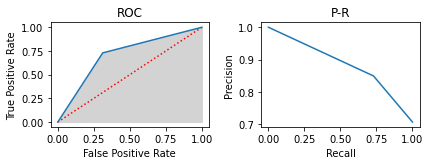

In [23]:
test_x=test[feat_cols]
test_y=test[out_col]
pre_y = lm_pipe.predict(test_x)
metric_count(test_y,pre_y)

### as we can see, the LogisticRegression model performs much better than the majority classification model. and from the test data, we can see there is not much overfit using this model.

              precision    recall  f1-score   support

         0.0       0.52      0.71      0.60      1739
         1.0       0.84      0.71      0.77      3835

    accuracy                           0.71      5574
   macro avg       0.68      0.71      0.68      5574
weighted avg       0.74      0.71      0.72      5574



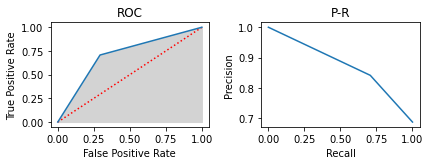

In [24]:
metric_count(train_y,lm_pipe.predict(train_x))

## random forest model

In [25]:
rf_pipe = Pipeline([
    ('columns', ColumnTransformer([

        ('log',FunctionTransformer(np.log1p),['rating_counts','vote_count','popularity','budget']),
        ('feature', OneHotEncoder(drop='first'), ['if_have_writers']),

    ])),
    ('model', RandomForestClassifier(class_weight='balanced',n_estimators=10))
])
rf_pipe.fit(train_x,train_y)
accuracy_score(train_y,rf_pipe.predict(train_x))

0.9876210979547901

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1739
         1.0       0.99      0.99      0.99      3835

    accuracy                           0.99      5574
   macro avg       0.98      0.99      0.99      5574
weighted avg       0.99      0.99      0.99      5574



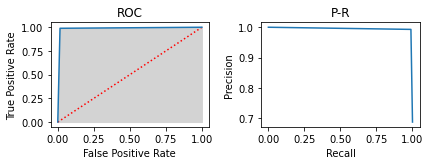

In [26]:
metric_count(train_y,rf_pipe.predict(train_x))

### as we can see, the random forest model performs better than the majority classification model. and from the test data, we can see that the model exists overfit problem.

              precision    recall  f1-score   support

         0.0       0.53      0.50      0.51       545
         1.0       0.80      0.82      0.81      1313

    accuracy                           0.72      1858
   macro avg       0.66      0.66      0.66      1858
weighted avg       0.72      0.72      0.72      1858



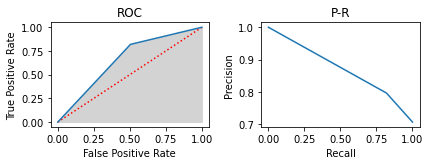

In [27]:
test_x=test[feat_cols]
test_y=test[out_col]
pre_y = rf_pipe.predict(test_x)
metric_count(test_y,pre_y)

## conclusion

In order to Predict whether  a movie is profitable, firstly we need to define a evaluation metric to determine if the movie is profitable. Here, we use (revenue-budget)>0 or not to decide a movie is profitable or not. we use 7 features here to predict the result. And finally, we use two machine learning models: LogisticRegression and random forest. to predict the outputs. The LogisticRegression model with L1 regularization has a accuracy  around 0.73 both in train and test data set while the random forest model has a high accuracy in train data but perform poor in test data, which shows a high overfit.Through this assigment, I find that Feature engineering is very important in data analysis. Feature engineering asks you to compare each features under the output. And the feature should have logical reason that it has in the result.Pipeline is very useful in machine learning.Regularization actually helps improve the model and it can reduce the posibility of overfitting. For the heavy imbalanced dataset, I use class_weight='balanced' as a parameter in each model to make the results more credible. it shows that it is helpful.

    